In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import time

In [2]:
def does_percolate_periodic(r1,r2,Nl,loss_inds):
    # r1 = r
    # r2 = r
    Gy = nx.Graph()
    Gy.add_nodes_from(np.arange(Nl*r1*(r2+1)))
    Gx = nx.Graph()
    Gx.add_nodes_from(np.arange(Nl*(r1+1)*r2))

#     for i3 range(Nl):
#         for i2 in range(r2):
#             for i1 in range(r1):
#                 ind1 = (i3*(r2+1)+i2)*r1+ i1
#                 ind2 = (i3*(r2+1)+i2)*r1 + ((i1+1)%r1)
#                 # cylinder along y
#                 if 2*ind1 in loss_inds:
#                     Gy.add_edge(ind1,ind2)
#                     if i2 ==0:
#                         Gy.add_edge((i3*(r2+1)+r2)*r1+ind1,(i3*(r2+1)+r2)*r1+ind2)
#                 if 2*ind1+1 in loss_inds:
#                     Gy.add_edge(i3*(r2+1)*r1+ind1,i3*(r2+1)*r1+ind1+r1)

#                 # cylinder along x
#                 ind2 = ((i2+1)%r2)*r1 + i1
#                 i2_g = ((i2+1)%r2)*(r1+1) + i1
#                 i1_g = i2*(r1+1)+ i1
#                 if 2*ind1+1 in loss_inds:
#                     Gx.add_edge(i1_g,i2_g)
#                     if i1 == 0 :
#                         Gx.add_edge(i1_g+r1,i2_g+r1) 
#                 if 2*ind1 in loss_inds:
#                     Gx.add_edge(i1_g,i1_g+1)
       
    Nq_l = 3*r1*r2
    for loss_index in loss_inds:
        ind1 = int(loss_index/3)
        z1 = int(loss_index/Nq_l)
        xy1 = loss_index%Nq_l
        if xy1  < 2*r1*r2: # data qubit
            x1 = int(xy1/2)%r1
            y1 = int(int(xy1/2)/r1)
            q1 = xy1*Nl + z1
            if xy1 % 2 == 0 :
                # q2 = (z1*r2+y1)*r1 + ((x1 +1 ) % r1)
                q2 = (y1*r1 + ((x1 +1 ) % r1))*Nl + z1
                Gy.add_edge(q1,q2)
                if y1 == 0:
                    Gy.add_edge(q1,q2+r1*Nl)
                        
                # i1_g = (z1*r2+y1)*(r1+1)+ x1
                i1_g = (y1*(r1+1) + x1)*Nl + z1
                Gx.add_edge(i1_g,i1_g+1)
            else:
                Gy.add_edge(q1,q1+r1*Nl)
                
                # i2_g = (z1*r2+((y1+1)%r2))*(r1+1) + x1
                i2_g = ( ((y1+1)%r2)*(r1+1) + x1)*Nl + z1
                Gx.add_edge(i1_g,i2_g)
                if x1 == 0 :
                    Gx.add_edge(i1_g+Nl*r1,i2_g+Nl*r1) 

        else: # ancilla qubit  ## stopped here...
            s1 = xy1 - 2*r1*r2
            q1 = s1*Nl + z1
            q2 = s1*Nl + ((z1+1)%Nl)
            Gy.add_edge(q1,q2)
            
            i1_g = s1*Nl + z1
            i2_g = ( ((y1+1)%r2)*(r1+1) + x1)*Nl + z1


            Gx.add_edge(i1_g,i1_g+1)

      
    first_row = np.arange(r1)
    last_row = np.arange(r2*r1,(r2+1)*r1)
    path_y = 0
    for i_first in first_row:
        for i_last in last_row:
            if nx.has_path(Gy,i_first,i_last):
                if (i_first - i_last )%r1 ==0:
                    path_y = 1
                    break

    first_col = np.arange(0,(r2-1)*(r1+1)+1,r1+1)
    last_col = np.arange(r1,r2*(r1+1)+1,r1+1)
    path_x = 0
    for i_first in first_col:
        for i_last in last_col:
            if nx.has_path(Gx,i_first,i_last):
                if int(i_first/(r1+1)) == int(i_last/(r1+1)):
                    path_x = 1
                    break
                    
    return path_x, path_y


def does_percolate_z(lx,ly,lz,loss_inds):
    G = nx.Graph()
    G.add_nodes_from(np.arange(lx*ly*(lz+1)))
    
    for loss_index in loss_inds:
        x1 = (int(loss_index/3)%(lx*ly))%lx
        y1 = int((int(loss_index/3)%(lx*ly))/lx)
        z1 = int(int(loss_index/3)/(lx*ly))
        
        if loss_index%3 ==0:
            x2 = (x1 +1 ) % lx
            y2 = y1
            z2 = z1
            q2 = (z2*ly+y2)*lx + x2
            G.add_edge(int(loss_index/3),q2)
            if z1==0:
                G.add_edge(lx*ly*lz+int(loss_index/3),lx*ly*lz+q2)
        elif loss_index%3 == 1:
            x2 = x1
            y2 = (y1+1) % ly
            z2 = z1            
            q2 = (z2*ly+y2)*lx + x2
            G.add_edge(int(loss_index/3),q2)
            if z1==0:
                G.add_edge(lx*ly*lz+int(loss_index/3),lx*ly*lz+q2)
        elif loss_index%3 == 2:
            x2 = x1
            y2 = y1
            z2 = (z1+1)
            q2 = (z2*ly+y2)*lx + x2
            G.add_edge(int(loss_index/3),q2)

                
    first_row = np.arange(lx*ly)
    last_row = np.arange(lz*lx*ly,(lz+1)*lx*ly)
    path = 0
    for i_first in first_row:
        for i_last in last_row:
            if nx.has_path(G,i_first,i_last):
                if (i_first - i_last )%(lx*ly) ==0:
                    path = 1
                    break
                    
    return path


In [3]:
def succ_prob_calc(B_orig, logicals_in, s_nodes, loss_inds):
    B = B_orig.copy()
    logicals = np.copy(logicals_in)
    s_nodes_set = set(np.copy(s_nodes))

    Ns_remain = len(s_nodes_set)
    q_remain = list(set(B.nodes())-s_nodes_set)
    node_list = list(s_nodes_set) + q_remain
    adj_mat_new = nx.to_numpy_array(B, nodelist = node_list)
    Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:]

    logic_succ = True
    for q in loss_inds:
        if logicals.ndim == 1:
            if logicals[q]>0:            
                st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                if len(st_ind)>0:
                    logicals = (logicals+Sx_mat[st_ind[0],:]) % 2
                else:
                    logic_succ = False
                    break
        else:
            for i_log in range(np.size(logicals,0)):
                if logicals[i_log,q]>0:            
                    st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                    if len(st_ind)>0:
                        logicals[i_log,:] = (logicals[i_log,:]+Sx_mat[st_ind[0],:]) % 2
                    else:
                        logic_succ = False
                        logicals[i_log,:] = np.zeros(np.size(logicals,1))
                        # break
            # if not logic_succ:
            #     break
            
        if q in B:
            sq = [n for n in B.neighbors(q)]
            if len(sq)==1:
                B.remove_nodes_from(sq)
                s_nodes_set -= set(sq)
            elif len(sq)>1:
                double_edgs = []
                for i in range(len(sq)-1):
                    n0 = set(B.neighbors(sq[i]))
                    n1 = set(B.neighbors(sq[i+1]))
                    rep_qs = n0.intersection(n1)
                    q0 = list(set(n0)-rep_qs)
                    q1 = list(set(n1)-rep_qs)
                    double_edgs += [(sq[i], e) for e in q0]
                    double_edgs += [(sq[i], e) for e in q1]
                G = nx.Graph()
                G.add_nodes_from(sq[:-1])
                G.add_edges_from(double_edgs)
                sq_remain = list(s_nodes_set-set(sq))
                for s in sq_remain:
                    G.add_edges_from([(s, e) for e in B.neighbors(s)])
                B = G
                s_nodes_set -= {sq[-1]}

            Ns_remain = len(s_nodes_set)
            if Ns_remain> 0:
                q_remain = list(set(B.nodes())-s_nodes_set)
                node_list = list(s_nodes_set) + q_remain
                adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                Sx_mat = np.zeros((Ns_remain,N))
                Sx_mat[:,q_remain] = Sx_red
            else:
                Sx_mat = []
                break

    if logicals.ndim == 1:
        logic_sum = np.sum(logicals)> 0
    else:
        # logic_sum = np.sum(np.sum(logicals,axis=1))> (np.size(logicals,0)-1)
        px = 0
        py = 0
        if np.sum(logicals[0,:])==0:
            py = 1
        if np.sum(logicals[1,:])==0:
            px = 1
    return px,py, (Ns_remain > 0), logicals, Sx_mat
    
#     succ_fail = 0
#     if Ns_remain > 0 and logic_sum and logic_succ:
#         succ_fail = 1

#     return succ_fail

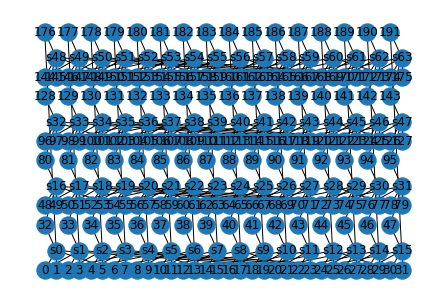

finished L = 4 in 12.4 secs


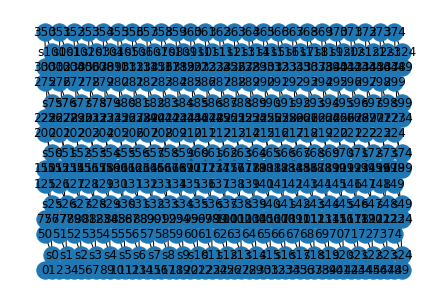

finished L = 5 in 44.2 secs


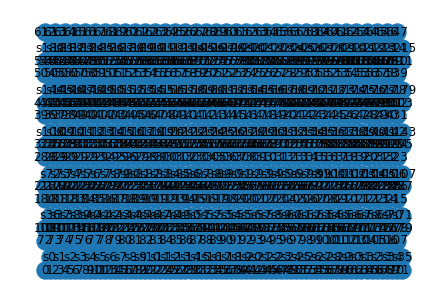

In [ ]:
# r1 = 6
# r2 = 6


Nl_list = np.arange(4,8)
p_list = np.linspace(0.01,0.4,20)
Nrep = 10
succ_prob = np.zeros((len(p_list),len(Nl_list)))

for i_L, Nl in enumerate(Nl_list):
    tic = time.time()
    
    r1, r2 = Nl, Nl
    # in layer stabilizer group
    Sx_mat = np.zeros((r1*r2,2*r1*r2),dtype=int)
    for i_y in range(r2):
        for i_x in range(r1):
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
            Sx_mat[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1

    Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
    Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer


    # Nl = 3 # number of layers in foliated code
    N = Nl*(Nq_l+Ns_l) # number of data qubits
    Ns = Nl*Ns_l # number of stabilizers
    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)
    for row in range(Ns_l):
        qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
        for i_l in range(Nl):
            B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+row), i_l*(Nq_l+Ns_l)+q) for q in qs])
    for i_l in range(Nl):
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), i_l*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), ((i_l-1)%Nl)*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])

    # pos = graphviz_layout(B_orig, prog="dot")
    pos = dict()
    for q in range(N):
        x_l = q%(Nq_l+Ns_l)
        x = x_l%r1
        y = int(x_l/r1)
        z = int(q/(Nq_l+Ns_l))
        if x_l >= Nq_l:
            pos[q] = (2*(x_l-Nq_l/2)-Nq_l,z+0.7)
            # pos[q] = (x,y,z)
        else:
            pos[q] = (x_l,z)
    for sq in range(Ns):
        x_l = (sq% Ns_l)
        x = x_l%r1
        y = int(x_l/r1)
        z = int(sq/Ns_l)
        pos["s%d" % sq] = (2*x_l+1,z+0.3)

    # pos  = nx.spring_layout(B_orig, k = 0.5)
    nx.draw(B_orig, pos,  with_labels=True)
    plt.show()

    logicals_l = np.zeros((2,2*r1*r2))
    logicals_l[0,1:2*r1:2] = np.ones(r1) 
    logicals_l[1,0:2*r1*r2:2*r1] = np.ones(r2) 

    logicals = np.zeros((2,N))
    for i_l in range(Nl):
        logicals[:,i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = logicals_l

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
            # succ_prob[i_p] += succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)
            
            loss_inds_x = np.zeros(len(loss_inds))
            loss_inds_y = np.zeros(len(loss_inds))
            Nd_l = Nq_l + Ns_l

            for i_loss, loss_index in enumerate(loss_inds):
                xy1 = loss_index%Nd_l
                z1 = int(loss_index/Nd_l)
                if xy1< Nq_l:
                    x1 = int(xy1/2)%r1
                    y1 = int(int(xy1/2)/r1)
                    if xy1 % 2 ==0:
                        loss_inds_x[i_loss]= 3*((x1*Nl+z1)*r2+y1 )+2
                        loss_inds_y[i_loss]= 3*((y1*Nl+z1)*r1+x1 )
                    else:
                        loss_inds_x[i_loss]= 3*((x1*Nl+z1)*r2+y1 )
                        loss_inds_y[i_loss]= 3*((y1*Nl+z1)*r1+x1 )+2 
                else:
                    x1 = (xy1-Nq_l)%r1
                    y1 = int((xy1-Nq_l)/r1)
                    loss_inds_x[i_loss]= 3*((x1*Nl+z1)*r2+y1 )+1
                    loss_inds_y[i_loss]= 3*((y1*Nl+z1)*r1+x1 )+1
                
            px = does_percolate_z(r2,Nl,r1,loss_inds_x)
            py = does_percolate_z(r1,Nl,r2,loss_inds_y)
            
            px_s, py_s, _, _, _ = succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)
            # print("stab:", px_s,py_s, stab)
            succ_prob[i_p,i_L] += (1-px_s)*(1-py_s)

            if not (px==px_s and py==py_s):
                print(i_rep)
                assert(0)

    toc = time.time()
    print("finished L = %d in %.1f secs" % (Nl,toc-tic))

succ_prob /= Nrep
print(succ_prob)